In [1]:
#Import Modules

#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

import pandas as pd

#advectionGP
from advectionGP.models import AdjointAdvectionDiffusionModel as PDEModel #Model module builds basic parts of the PDE problem, combines other classes into full model
from advectionGP.models import AdjointSimpleODEModel as ODEModel #Model module builds basic pa
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model

#Plotting tools
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Generate Observations Using Physical Model

### Generate Training and Testing Sensor Locations

In [2]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,8,3) # lower time
xloc=np.linspace(2,8,4) # x locations
yloc=np.linspace(2,8,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+1 # upper time

sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging

# generate sensor locations for test data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(2,9,5) # lower time
xloc=np.linspace(1.5,7.5,4) # x locations
yloc=np.linspace(1.5,7.5,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
Xtest= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
Xtest[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] 
Xtest[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1]
Xtest[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2]
Xtest[:,1] = Xtest[:,0]+1

sensorsTest = FixedSensorModel(Xtest,1) # establish sensor model

### Run Forward Model to Compute Concentration

In [3]:
k_0 = 0.00001 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,30,30] # grid size for time, x and y
wind=np.cos(np.linspace(0,6*np.pi,res[1]))*0.5
u=[]
#u.append(np.ones(res)*wind) #x direction wind
#u.append(np.ones(res)*0.0) # y direction wind

u.append(np.ones(res)*0.00001) #x direction wind
u.append(np.ones(res)*0.00001) # y direction wind
m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,u=u,k_0=k_0) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
source=(m.computeSourceFromPhi(z))# Compute source
#source[source<0]=0

#source = np.zeros(m.resolution)
##source[0,int(Nx/2)-1,int(Ny/2)-1] = 10.0
#source[:,15:25,15:25] = 5
#source[:,2:7,2:7] = 25
#source[:,7:12,15:20] = 25
#source[:,18:28,10:20] = 25

### Generate Training and Testing Data

In [4]:
concTrain=m.computeConcentration(source) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

m.sensormodel=sensorsTest
yTest= m.computeObservations()

# Inverse Problem

In [5]:
N_feat =200 #Number of features used to infer the source
k = EQ(2, 2.0) 

mPDE = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,u=u,k_0=k_0) #Initiate new model for inference
regressPDE = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE, covZPDE = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourcePDE = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distributio

mODE = ODEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors) #Initiate new model for inference
regressODE = mODE.computeModelRegressors() # Compute regressor matrix
meanZODE, covZODE = mODE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceODE = mODE.computeSourceFromPhi(meanZODE) # Generates estimated source using inferred distribution

Calculating Adjoints...
47/48 
Calculating Phis...
199/200 
Calculating Adjoints...
47/48 
Calculating Phis...
199/200 


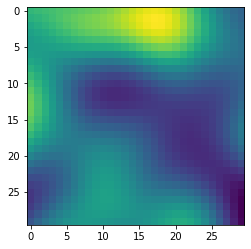

In [6]:
plt.imshow(concTrain[49])

# Plot Mean Sources for Comparison

In [7]:
(np.square(np.subtract(source,sourceODE))).mean() 

1.9300938770672067

In [8]:
(np.square(np.subtract(source,sourcePDE))).mean() 

1.4486134732792082

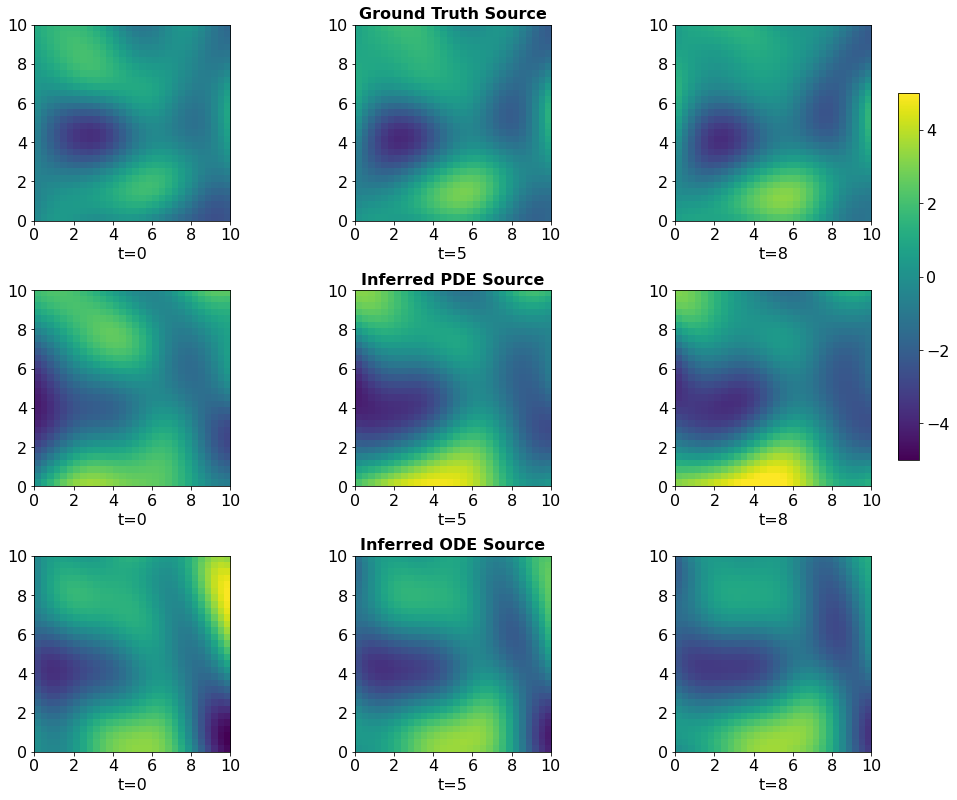

In [9]:
a=np.floor(np.min((np.min(sourceODE),np.min(source),np.min(sourcePDE))))
b=np.ceil(np.max((np.max(sourceODE),np.max(source),np.min(sourcePDE))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Source','Inferred PDE Source','Inferred ODE Source'],[source,sourcePDE,sourceODE]):
    for t in [0,5,8]:
        ploti+=1
        plt.subplot(3,3,ploti)
        im1=plt.imshow(data[t], extent=[0,10,0,10],origin='lower') #fix t...
        plt.xlabel("t=%d" % t,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.clim(a,b)
        
        
        tick_font_size = 16
        if ploti % 3 == 2: plt.title(title, fontsize=16, fontweight='bold')
        #if ploti % 3 == 3:
        #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 0.95])

fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.97, 0.52, 0.02, 0.34])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

In [10]:
reps=100
llObsPDE=0
llObsODE=0
MSEPDE=0
MSEODE=0
cMSEPDE=0
cMSEODE=0
negPercent=0
var = np.ones(len(yTest))*noiseSD**2
for j in range(reps):
    mPDE.sensormodel=sensors
    z = np.random.multivariate_normal(meanZPDE,covZPDE)
    source = mPDE.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
    conc=mPDE.computeConcentration(source) # Compute test concentration
    mPDE.sensormodel=sensorsTest
    yPDE= mPDE.computeObservations(addNoise='TRUE') # Compute observations with noise
    llObsPDE += 0.5*np.sum((np.square(np.subtract(yTest,yPDE))/var)+0.5*np.log(var))
    MSEPDE += (np.square(np.subtract(yTest,yPDE))).mean() 
    cMSEPDE += (np.square(np.subtract(conc,concTrain))).mean() 
    mODE.sensormodel=sensors
    z = np.random.multivariate_normal(meanZODE,covZODE)
    source = mODE.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
    conc=mODE.computeConcentration(source) # Compute test concentration
    mODE.sensormodel=sensorsTest
    yODE= mODE.computeObservations(addNoise='TRUE') # Compute observations with noise
    llObsODE += 0.5*np.sum((np.square(np.subtract(yTest,yODE))/var)+0.5*np.log(var))
    MSEODE += (np.square(np.subtract(yTest,yODE))).mean() 
    cMSEODE += (np.square(np.subtract(conc,concTrain))).mean() 
llObsODE = llObsODE/reps
MSEODE=MSEODE/reps
cMSEODE=cMSEODE/reps
llObsPDE = llObsPDE/reps
MSEPDE = MSEPDE/reps
cMSEPDE = cMSEPDE/reps

Results = pd.DataFrame([[llObsPDE,MSEPDE,cMSEPDE],[llObsODE,MSEODE,cMSEODE]])
Results.columns=['Log like','Source MSE','ConcMSE']


In [11]:
Results


,Log like,Source MSE,ConcMSE
0,2.324790e+06,145.306871,113.875210
1,4.055604e+04,2.542242,22.232013


In [12]:
[[llObsPDE,MSEPDE,cMSEPDE],[llObsODE,MSEODE,cMSEODE]]

[[2324790.099538146, 145.3068705518181, 113.87521036486422],
 [40556.0448938104, 2.542242136547035, 22.23201330760476]]

In [13]:
yTest

array([-3.00865707e-01,  3.30719528e+00,  6.40292607e+00,  2.17434678e+00,
        1.51944235e+00,  5.97248150e+00,  1.02752553e+01,  4.85975171e+00,
        4.11156429e+00,  7.87106185e+00,  1.34908745e+01,  8.56135004e+00,
        6.56886446e+00,  9.56590487e+00,  1.58695102e+01,  1.12123268e+01,
        8.82570943e+00,  1.19978435e+01,  1.82767001e+01,  1.29439735e+01,
       -6.41944489e+00, -5.41783584e+00, -1.61892252e-01, -1.21922967e+00,
       -7.62548230e+00, -8.74892267e+00, -2.63585527e+00, -3.34962196e+00,
       -5.84020554e+00, -1.12614318e+01, -5.89534680e+00, -5.13026168e+00,
       -2.39676782e+00, -1.17372300e+01, -7.97257607e+00, -5.65413546e+00,
        1.05551847e+00, -1.07380118e+01, -7.95984462e+00, -5.21497916e+00,
       -4.23781094e+00, -3.87517885e+00, -7.12335828e-01, -4.44349290e+00,
       -5.37280357e+00, -6.90284741e+00, -3.79932128e+00, -9.16112144e+00,
       -3.92995661e+00, -8.76532686e+00, -7.97931566e+00, -1.34480382e+01,
       -6.16289460e-01, -

In [14]:
yODE

array([  0.60447647,   4.32618703,   7.08263892,   4.27334396,
         1.88821593,   7.00658386,  11.09516449,   7.51706272,
         2.53562791,   8.07956865,  13.64942728,   9.53082198,
         4.8839205 ,   9.43721914,  16.21907413,  11.57400943,
         7.96855733,  11.72653489,  20.8354566 ,  15.87429384,
        -6.34391152,  -5.29980407,  -0.99371694,  -0.84242741,
        -8.26756431,  -8.18875784,  -3.6118893 ,  -2.48171646,
        -6.77584162, -10.18912745,  -6.86592718,  -4.91600081,
        -2.6349993 , -10.66904521,  -8.31411617,  -5.63460495,
         0.46250748, -11.90722346,  -8.49182086,  -5.96128569,
        -5.60494911,  -3.72612627,  -1.27317426,  -4.04632122,
        -7.89586598,  -6.54518566,  -5.0352307 ,  -7.99685659,
        -6.23506457,  -6.25455164,  -8.54059384, -11.39787551,
        -2.49576322,  -4.99748808,  -9.65359692, -13.24435751,
        -2.00817238,  -8.38487325, -11.97302577, -15.53044272,
         0.58449677,   2.40787057,   1.28613391,  -3.77

In [15]:
yPDE

array([ -0.40365861,   0.878414  ,   0.83319492,   1.11044183,
         1.72025614,   4.43241739,   1.61152927,  -1.86373825,
         4.25115136,   9.13379047,   2.45578196,  -6.33404696,
         6.62697481,  11.60188175,   2.31470069,  -7.31461221,
         7.21881333,  10.86973125,   2.04096422,  -3.75612589,
        -0.42062497,   1.08438696,   2.55611233,   2.03467079,
         1.20045553,   0.66366663,   2.71197171,   1.42860971,
         2.43839419,  -2.11340679,   1.00812951,   0.2465117 ,
         3.06665472,  -4.15343304,   1.78017962,   2.73607378,
         2.82221065,  -4.51837907,   4.62684456,   6.93032661,
         0.39462336,   2.86586461,   8.37144571,   1.5000345 ,
        -1.7872358 ,   0.09297028,  12.09654763,   4.83662581,
        -5.90870861,  -4.9752981 ,  13.53458144,   7.12905296,
        -7.44646469,  -6.61862446,  15.55043862,   8.23284654,
        -6.52920942,  -6.62989953,  16.42978068,   7.75560918,
        -3.71695458,   1.49514533,  12.50604591,   5.47

In [16]:
mPDE.sensormodel=sensors
z = np.random.multivariate_normal(meanZPDE,covZPDE)
source = mPDE.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
conc=mPDE.computeConcentration(source) # Compute test concentration

In [17]:
 mODE.sensormodel=sensors
z = np.random.multivariate_normal(meanZODE,covZODE)
source = mODE.computeSourceFromPhi(z) # Generates estimated source using inferred distribution
conc=mODE.computeConcentration(source) # Compute test concentration

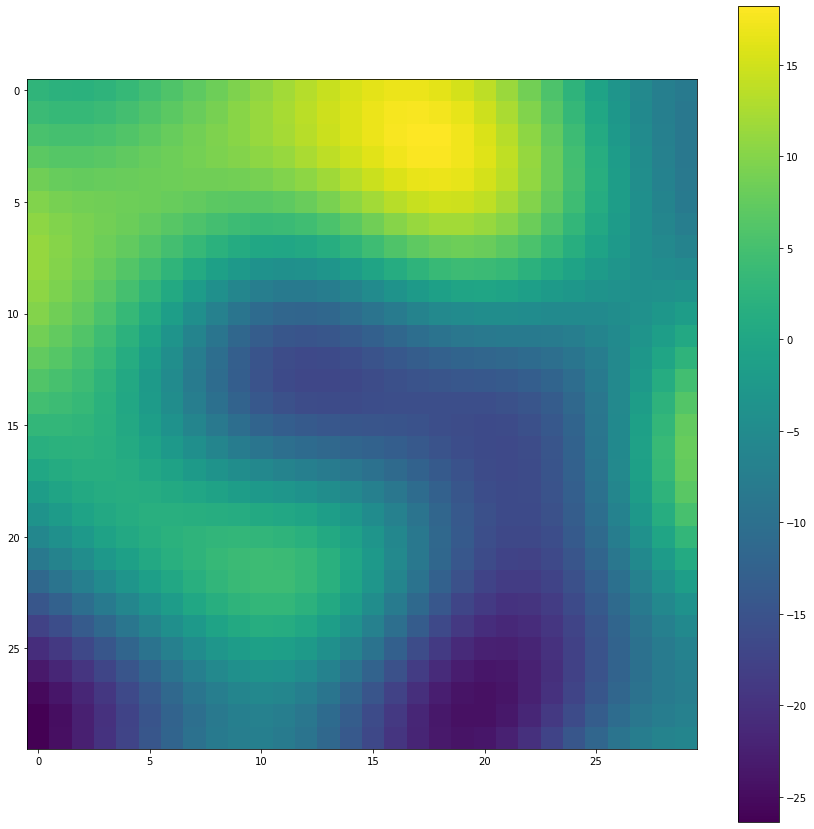

In [18]:
plt.imshow(conc[49])
plt.colorbar()

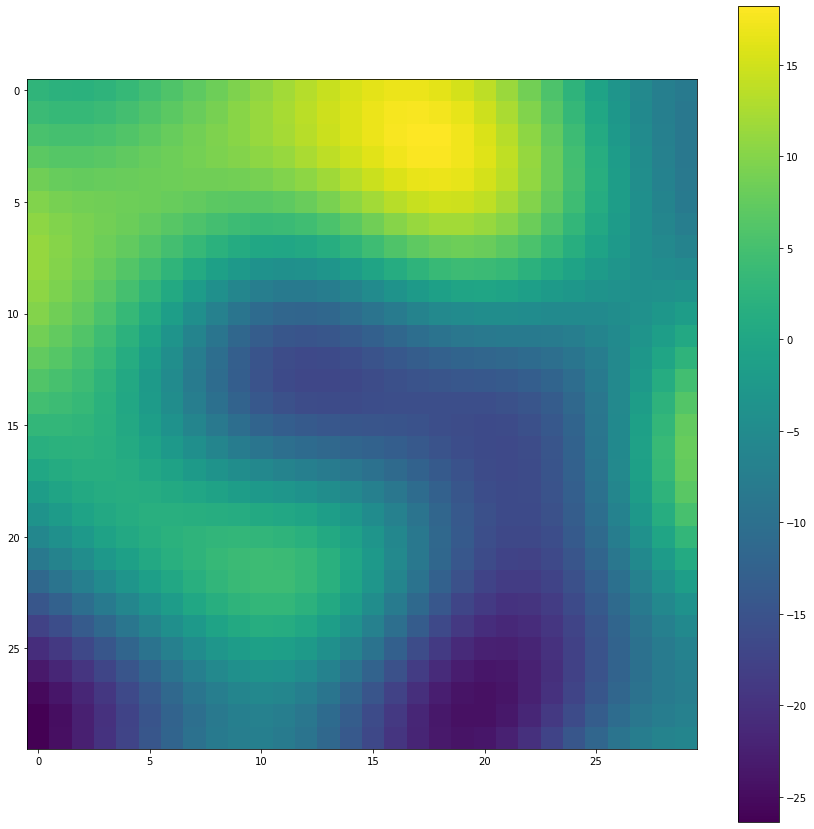

In [19]:
plt.imshow(conc[49])
plt.colorbar()

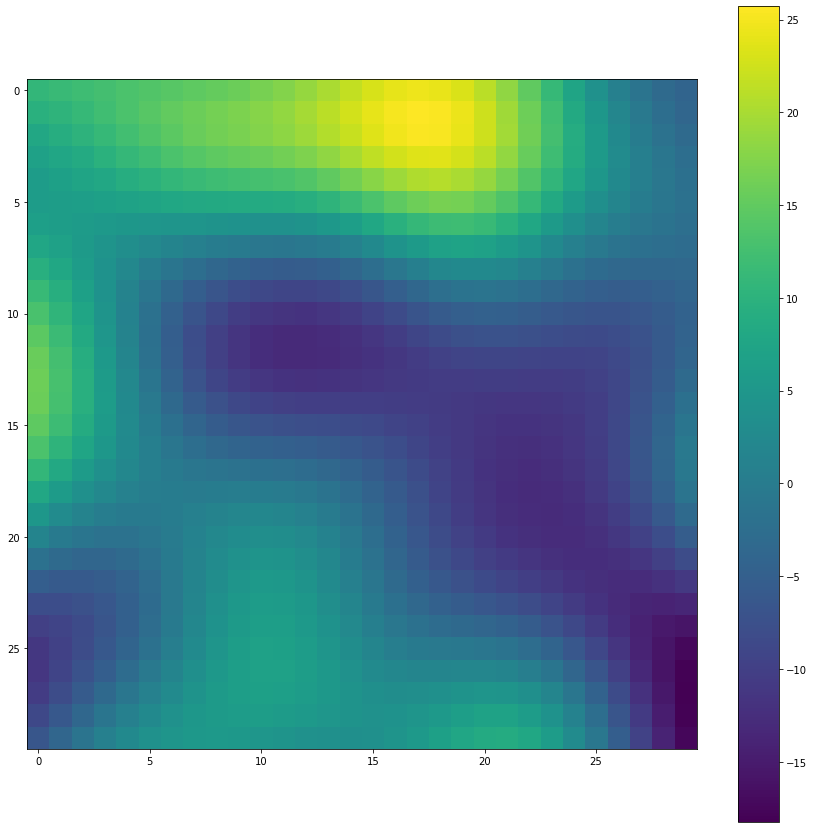

In [20]:
plt.imshow(concTrain[49])
plt.colorbar()